In [32]:
import itertools as it
from collections import deque
from copy import deepcopy
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [4]:
def parse_input(fl):
    with open(fl) as infile:
       grid = [list(ln.strip()) for ln in infile.readlines()]
    m, n = (len(grid), len(grid[0]))
    s_pos = None
    for i, j in it.product(range(m), range(n)):
        if grid[i][j] == 'S':
            s_pos = (i, j)
    return {
        's': s_pos,
        'grid': grid,
        'shape': (m, n)
    }

In [13]:
test = parse_input("data/day10-test.txt")
test2 = parse_input("data/day10-test2.txt")
inputs = parse_input("data/day10-input.txt")
test

{'s': (2, 0),
 'grid': [['.', '.', 'F', '7', '.'],
  ['.', 'F', 'J', '|', '.'],
  ['S', 'J', '.', 'L', '7'],
  ['|', 'F', '-', '-', 'J'],
  ['L', 'J', '.', '.', '.']],
 'shape': (5, 5)}

### Part 1

```
.....
.F-7.
.|.|.
.L-J.
.....
```

In [6]:
def part1(data, debug=False):
    data = deepcopy(data)
    grid = _modify_s(data)
    q = deque([data['s']])
    seen = set([data['s']])
    lvl = 0
    grid_dists = np.array(deepcopy(grid))
    grid_visited = np.array(deepcopy(grid))
    while q:
        qlen = len(q)
        for _ in range(qlen):
            i, j = q.popleft()
            grid_dists[i][j] = lvl
            grid_visited[i][j] = '*'
            for nb in iter_adj(cur=(i, j), grid=grid, shape=data['shape']):
                if nb in seen:
                    continue
                seen.add(nb)
                q.append(nb)
        lvl += 1
    if debug:
        print("Dists")
        pprint(grid_dists)
        print("Visited as *")
        pprint(grid_visited)
    return {
        'lvl': lvl - 1,
        'dists': grid_dists,
        'visited_grid': grid_visited,
        'visited_nodes': seen,
    }


def _modify_s(data):
    grid, (i, j), (m, n) =data['grid'], data['s'], data['shape']
    to_ups = {'|', 'F', '7'}
    to_downs = {'|', 'L', 'J'}
    to_lts = {'-', 'L', 'F'}
    to_rts = {'-', 'J', '7'}
    s = None
    if grid[i+1][j] == grid[i-1][j] == '|':
        s = '|'
    elif grid[i][j-1] == grid[i][j+1] == '-':
        s = '-'
    elif grid[i-1][j] in to_ups and grid[i][j+1] in to_rts:
        s = 'L'
    elif grid[i-1][j] in to_ups and grid[i][j-1] in to_lts:
        s = 'J'
    elif grid[i+1][j] in to_downs and grid[i][j-1] in to_lts:
        s = '7'
    elif grid[i+1][j] in to_downs  and grid[i][j+1] in to_rts:
        s = 'F'
    else:
        raise RuntimeError("Unknown situation")
    grid[i][j] = s
    return grid


def iter_adj(cur, grid, shape):
    pipe2deltas = {
        '|': {(-1,0), (1,0)},
        '-': {(0,-1), (0,1)},
        'L': {(-1,0), (0,1)},
        'J': {(0,-1), (-1,0)},
        '7': {(1,0), (0,-1)},
        'F': {(0,1), (1,0)},
    }
    i, j = cur
    m, n = shape
    for idel, jdel in pipe2deltas[grid[i][j]]:
        adj_i, adj_j = i+idel, j+jdel
        if 0<= adj_i < m and 0 <= adj_j < n:
            yield (adj_i, adj_j)

In [7]:
part1(data=test, debug=True)

Dists
array([['.', '.', '4', '5', '.'],
       ['.', '2', '3', '6', '.'],
       ['0', '1', '.', '7', '8'],
       ['1', '4', '5', '6', '7'],
       ['2', '3', '.', '.', '.']], dtype='<U1')
Visited as *
array([['.', '.', '*', '*', '.'],
       ['.', '*', '*', '*', '.'],
       ['*', '*', '.', '*', '*'],
       ['*', '*', '*', '*', '*'],
       ['*', '*', '.', '.', '.']], dtype='<U1')


{'lvl': 8,
 'dists': array([['.', '.', '4', '5', '.'],
        ['.', '2', '3', '6', '.'],
        ['0', '1', '.', '7', '8'],
        ['1', '4', '5', '6', '7'],
        ['2', '3', '.', '.', '.']], dtype='<U1'),
 'visited_grid': array([['.', '.', '*', '*', '.'],
        ['.', '*', '*', '*', '.'],
        ['*', '*', '.', '*', '*'],
        ['*', '*', '*', '*', '*'],
        ['*', '*', '.', '.', '.']], dtype='<U1'),
 'visited_nodes': {(0, 2),
  (0, 3),
  (1, 1),
  (1, 2),
  (1, 3),
  (2, 0),
  (2, 1),
  (2, 3),
  (2, 4),
  (3, 0),
  (3, 1),
  (3, 2),
  (3, 3),
  (3, 4),
  (4, 0),
  (4, 1)}}

In [8]:
part1(data=inputs)['lvl']

6800

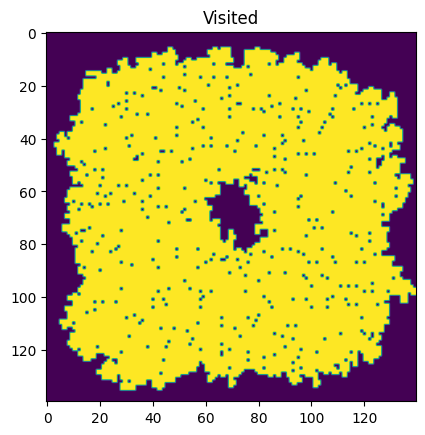

In [9]:
visited = part1(data=inputs)['visited_grid']
visited_gray = (visited == '*').astype(np.uint8)
plt.imshow(visited_gray);
plt.title('Visited');

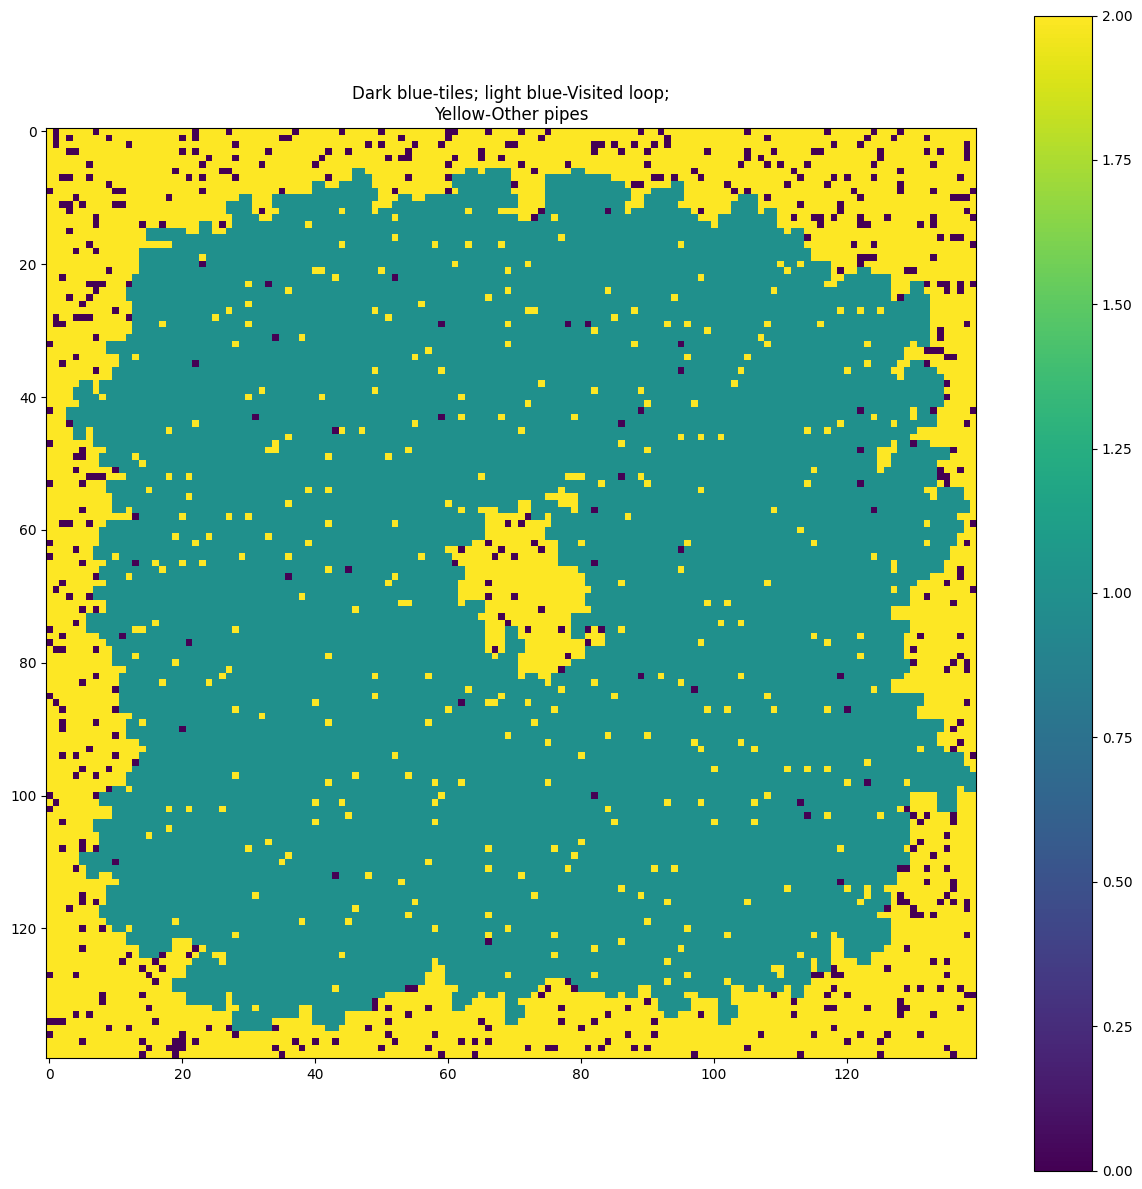

In [55]:
im = deepcopy(part1(data=inputs)['visited_grid'])
im[im=='.'] = '0' # tiles
im[im=='*'] = '1' # visited
im[(im != '0') & (im != '1')] = '2' # other pipes
plt.figure(figsize=(15,15))
plt.imshow(im.astype(np.uint8));
plt.title('Dark blue-tiles; light blue-Visited loop;\nYellow-Other pipes');
plt.colorbar();

### Part 2
From any of the visited node, dfs onto any adjacent `'.'`. To determine whether we are within the pipe region or outside we can just check the two neighbour pipes and we only do these at intersections.

```
.....
.F-7.
.|.|.
.L-J.
.....
```

In [36]:
def part2(data):
    part1_ans = part1(data=data, debug=False)
    grid = _modify_s(data)
    path_nodes = part1_ans['visited_nodes']
    seen_tiles = set()
    ntiles = 0
    for n in path_nodes:
        i, j = n
        cur = grid[i][j]
        if cur not in {'F', '7', 'L', 'J'}:
            continue
        if cur == 'F' and grid[i+1][j+1] == '.':
            new_node = (i+1, j+1)
        elif cur == '7' and grid[i+1][j-1] == '.':
            new_node = (i+1, j-1)
        elif cur == 'J' and grid[i-1][j-1] == '.':
            new_node = (i-1, j-1)
        elif cur == 'L' and grid[i-1][j+1] == '.':
            new_node = (i-1, j+1)
        else:
            continue
        seen_tiles.add(new_node)
        ntiles += count_tiles(node=new_node, grid=grid, seen_tiles=seen_tiles)
    print(np.array(grid))
    print(part1_ans['visited_grid'])
    vgrid = deepcopy(part1_ans['visited_grid']) 
    for ti, tj in seen_tiles:
        vgrid[ti][tj] = 'I'
    print(vgrid)
    return ntiles


def count_tiles(node, grid, seen_tiles):
    tot = 1
    for adj in _iter_adj_tiles(node=node, grid=grid, seen_tiles=seen_tiles):
        seen_tiles.add(adj)
        tot += count_tiles(node=adj, grid=grid, seen_tiles=seen_tiles)
    return tot


def _iter_adj_tiles(node, grid, seen_tiles):
    m, n = len(grid), len(grid[0])
    i, j = node
    for i_adj, j_adj in it.product(range(i-1, i+2), range(j-1, j+2)):
        if (
            (0 <= i_adj < m)
            and (0 <= j_adj < n)
            and grid[i_adj][j_adj] == '.'
            and (i_adj, j_adj) not in seen_tiles
        ):
            yield (i_adj, j_adj)

In [37]:
part2(data=test2)

[['.' 'F' '-' '-' '-' '-' '7' 'F' '7' 'F' '7' 'F' '7' 'F' '-' '7' '.' '.' '.' '.']
 ['.' '|' 'F' '-' '-' '7' '|' '|' '|' '|' '|' '|' '|' '|' 'F' 'J' '.' '.' '.' '.']
 ['.' '|' '|' '.' 'F' 'J' '|' '|' '|' '|' '|' '|' '|' '|' 'L' '7' '.' '.' '.' '.']
 ['F' 'J' 'L' '7' 'L' '7' 'L' 'J' 'L' 'J' '|' '|' 'L' 'J' '.' 'L' '-' '7' '.' '.']
 ['L' '-' '-' 'J' '.' 'L' '7' '.' '.' '.' 'L' 'J' 'F' '7' 'F' '-' '7' 'L' '7' '.']
 ['.' '.' '.' '.' 'F' '-' 'J' '.' '.' 'F' '7' 'F' 'J' '|' 'L' '7' 'L' '7' 'L' '7']
 ['.' '.' '.' '.' 'L' '7' '.' 'F' '7' '|' '|' 'L' '7' '|' '.' 'L' '7' 'L' '7' '|']
 ['.' '.' '.' '.' '.' '|' 'F' 'J' 'L' 'J' '|' 'F' 'J' '|' 'F' '7' '|' '.' 'L' 'J']
 ['.' '.' '.' '.' 'F' 'J' 'L' '-' '7' '.' '|' '|' '.' '|' '|' '|' '|' '.' '.' '.']
 ['.' '.' '.' '.' 'L' '-' '-' '-' 'J' '.' 'L' 'J' '.' 'L' 'J' 'L' 'J' '.' '.' '.']]
[['.' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '.' '.' '.' '.']
 ['.' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '*' '.' '.' '.' '.']
 ['

63